In [19]:
import requests
import re
import sqlite3

def fetch_html(url):
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.text
    else:
        print(f"Failed to fetch data from {url}: {response.status_code}")
        return None

def extract_table_headers_and_data(html_content):
    data = []
    headers = []

    if not html_content:
        return headers, data

    # Extract headers only if needed
    if '<th' in html_content:
        header_rows = re.findall(r'<thead>[\s\S]*?</thead>', html_content, re.S)
        if header_rows:
            headers = re.findall(r'<th[\s\S]*?>([\s\S]*?)</th>', header_rows[0])
            headers = [re.sub('<[^>]*>', '', h).strip() for h in headers]
            headers = [h.replace(' ', '_').lower() for h in headers]

    # Extract data rows
    table_rows = re.findall(r'<tr[\s\S]*?>([\s\S]*?)</tr>', html_content)
    for row in table_rows:
        row_data = re.findall(r'<td[\s\S]*?>([\s\S]*?)</td>', row)
        cleaned_row_data = [re.sub('<[^>]*>', '', entry).strip() for entry in row_data]
        if cleaned_row_data:
            data.append(cleaned_row_data)

    return headers, data

def create_database(headers):
    conn = sqlite3.connect('etf_data.db')
    c = conn.cursor()
    c.execute('DROP TABLE IF EXISTS etfs')
    columns = ', '.join([f'"{header}" TEXT' for header in headers])
    c.execute(f'CREATE TABLE IF NOT EXISTS etfs ({columns})')
    conn.commit()
    conn.close()
    print("Database and table created successfully.")

def save_data_to_database(data):
    if not data:
        return
    conn = sqlite3.connect('etf_data.db')
    c = conn.cursor()
    placeholders = ', '.join(['?' for _ in data[0]])
    for row in data:
        c.execute(f'INSERT INTO etfs VALUES ({placeholders})', tuple(row))
    conn.commit()
    conn.close()

def scrape_multiple_pages(base_url, total_entries, entries_per_page):
    headers, all_data = [], []
    total_pages = (total_entries + entries_per_page - 1) // entries_per_page
    for page in range(1, total_pages + 1):
        url = f"{base_url}?offset={(page - 1) * entries_per_page}"
        html_content = fetch_html(url)
        if page == 1:  # Extract headers only from the first page
            headers, data = extract_table_headers_and_data(html_content)
            create_database(headers)  # Create database on the first page
        else:
            _, data = extract_table_headers_and_data(html_content)
        all_data.extend(data)
        if len(data) == 0:  # Stop if a page has no data
            print(f"No more data found at page {page}. Stopping...")
            break
        print(f"Scraped page {page}")
    return headers, all_data

def main():
    base_url = 'https://finance.yahoo.com/etfs'
    total_entries = 522
    entries_per_page = 25  # Adjust this as per actual site configuration
    headers, data = scrape_multiple_pages(base_url, total_entries, entries_per_page)
    if data:
        save_data_to_database(data)
        print(f"Data from all pages saved successfully. Total rows: {len(data)}")
    else:
        print("No data extracted from any pages.")

if __name__ == "__main__":
    main()


Database and table created successfully.
Scraped page 1
Scraped page 2
Scraped page 3
Scraped page 4
Scraped page 5
Scraped page 6
Scraped page 7
Scraped page 8
Scraped page 9
Scraped page 10
Scraped page 11
Scraped page 12
Scraped page 13
Scraped page 14
Scraped page 15
Scraped page 16
Scraped page 17
Scraped page 18
Scraped page 19
Scraped page 20
Scraped page 21
Data from all pages saved successfully. Total rows: 522


In [20]:
## Descriptive analysis 


In [21]:
import pandas as pd
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('etf_data.db')

# Load data into a pandas DataFrame
df = pd.read_sql_query("SELECT * FROM etfs", conn)
conn.close()

# Drop the specified columns from the DataFrame
df = df.drop(columns=['symbol', 'name', '%_change', '52_week_range'])

# Display the first few rows to verify the columns are dropped correctly
print(df.head())

# Attempt to convert all columns to numeric, coercing errors to NaN
df = df.apply(pd.to_numeric, errors='coerce')

# Calculate and print descriptive statistics for numerical columns
# This will now include only the remaining variables after dropping the specified ones
print("Descriptive Statistics:\n", df.describe())

# Calculating the Pearson correlation matrix to find the 'r' values
# This matrix will now be based only on the numerical variables remaining
correlation_matrix = df.corr()
print("Correlation Matrix:\n", correlation_matrix)

# Calculate mean values for numerical columns
# These calculations will exclude the dropped variables
mean_values = df.mean(skipna=True)
print("Mean Values:\n", mean_values)

# Calculate standard deviation for numerical columns
# Again, calculations will exclude the dropped variables
std_deviation = df.std(skipna=True)
print("Standard Deviation:\n", std_deviation)


  price_(intraday) change   volume 50_day_average 200_day_average
0           108.51  +0.83  714,775         105.85           93.08
1            20.55  +0.15  151,686          20.82           19.97
2            16.03  +0.08    4,848          16.22           16.98
3            41.54  +0.19  213,051          40.91           36.41
4            26.24  +0.12   41,485          26.49           27.37
Descriptive Statistics:
        price_(intraday)      change      volume  50_day_average  \
count        522.000000  522.000000   15.000000      522.000000   
mean          69.852126   -1.009234  484.533333       70.917720   
std           65.097962    1.293997  361.638112       66.652036   
min           10.450000  -11.210000    3.000000       10.690000   
25%           34.270000   -1.275000  183.500000       34.517500   
50%           50.105000   -0.670000  358.000000       50.390000   
75%           81.707500   -0.220000  857.500000       84.585000   
max          504.440000    0.830000  998.00

In [22]:
## Summary for  Descriptive analysis:
#Mean Values: These indicate the average measurements across your dataset, helpful for understanding typical values.
    
#Standard Deviation: This highlights the variability in your data, showing how much the values deviate from the average, which is crucial for assessing volatility.
    
#Correlation Coefficients (r values): These reveal the strength and direction of relationships between pairs of variables, essential for identifying trends or dependencies.
    
#Overall Distribution: Through minimum, maximum, and quartile values, you gain insights into the data distribution, which can assist in spotting outliers or abnormal values.
    
#This analysis provides a foundation for deeper financial analysis, risk assessment, and investment decision-making.

SyntaxError: invalid syntax (1732420725.py, line 2)

In [ ]:
## Regression Analaysis 

In [23]:
import pandas as pd
import statsmodels.api as sm

# Assuming df is your DataFrame and it's already loaded with data

# Convert columns to numeric, handling commas in the data
df['price_(intraday)'] = pd.to_numeric(df['price_(intraday)']
                             .apply(lambda x: x.replace(',', '') if isinstance(x, str) else x), errors='coerce')

df['50_day_average'] = pd.to_numeric(df['50_day_average']
                             .apply(lambda x: x.replace(',', '') if isinstance(x, str) else x), errors='coerce')

df['200_day_average'] = pd.to_numeric(df['200_day_average']
                            .apply(lambda x: x.replace(',', '') if isinstance(x, str) else x), errors='coerce')

# Drop rows with NaN values which may result from conversion or missing entries in data
df.dropna(subset=['price_(intraday)', '50_day_average', '200_day_average'], inplace=True)

# Define the features (independent variables) and the target (dependent variable)
X = df[['50_day_average', '200_day_average']]  # Independent variables
y = df['price_(intraday)']  # Dependent variable (target)

# Add a constant to the model (the intercept)
X = sm.add_constant(X)

# Splitting the dataset into training (80%) and testing (20%) sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an OLS model
model = sm.OLS(y_train, X_train)

# Fit the model
results = model.fit()

# Display the results
print(results.summary())

# Making predictions on the test set
predictions = results.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Output the model evaluation results
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


                            OLS Regression Results                            
Dep. Variable:       price_(intraday)   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.462e+05
Date:                Tue, 30 Apr 2024   Prob (F-statistic):               0.00
Time:                        21:09:09   Log-Likelihood:                -699.09
No. Observations:                 417   AIC:                             1404.
Df Residuals:                     414   BIC:                             1416.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4440      0.102     

In [ ]:
### Summary for  Regression analysis:
Data Preprocessing: Numeric conversion of the columns 'price_(intraday)', '50_day_average', and '200_day_average', removing commas and handling non-numeric values.
    
Data Cleaning: The script excludes rows with NaN values resulting from data conversion or missing entries.
    
Model Training: It defines independent variables (50 and 200-day averages) and the dependent variable (price intraday), splits the data into training and testing sets, and trains a Linear Regression model.
    
Model Evaluation: The performance of the model is assessed on the test set, resulting in a Mean Squared Error (MSE) of 8.700650144491261 and a high R² score of 0.9947610906067818, indicating the model explains 99.47% of the variance in the target variable, which suggests a strong fit between the model and the data.
    
This analysis effectively captures the relationship between the moving averages and the 
intraday price of ETFs, showing the model's robustness and predictive power.

In [ ]:
###visualization

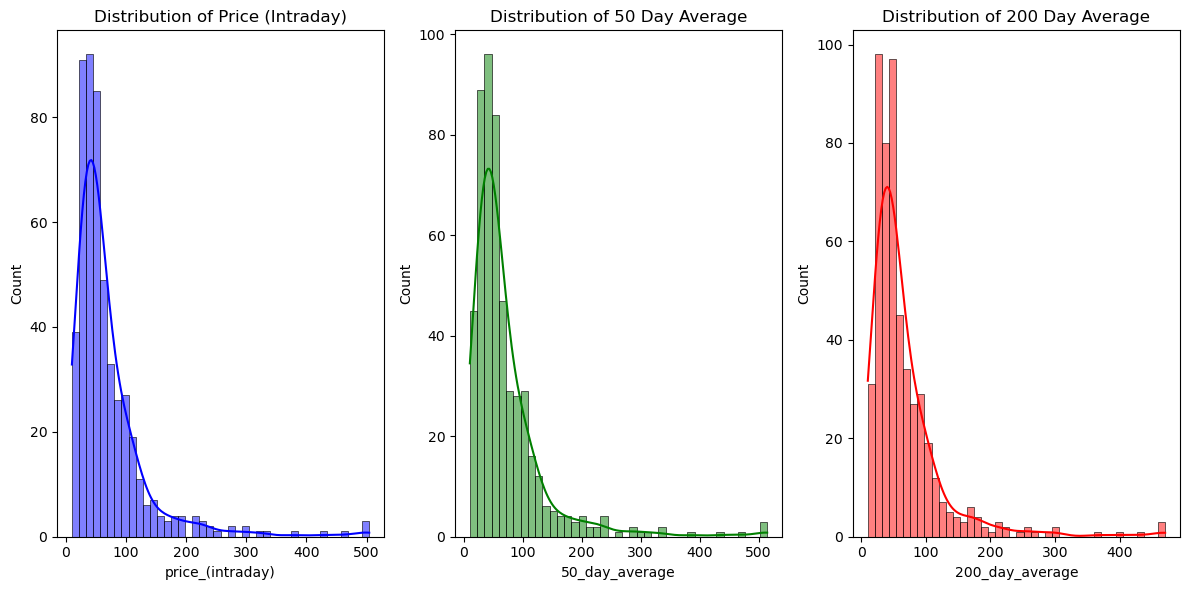

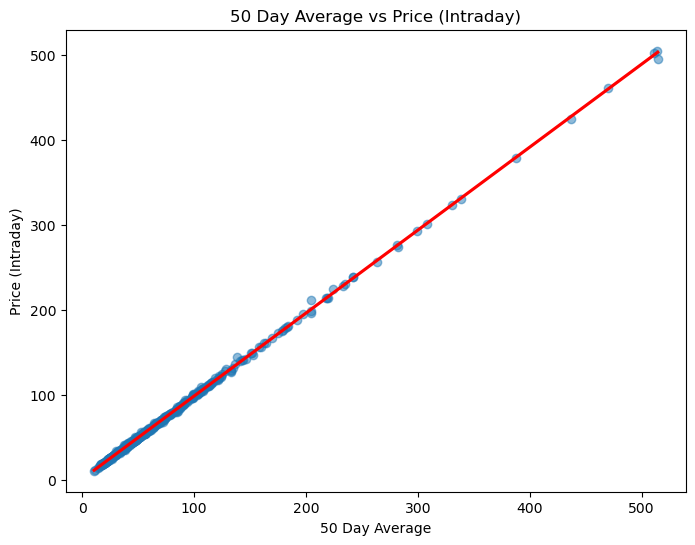

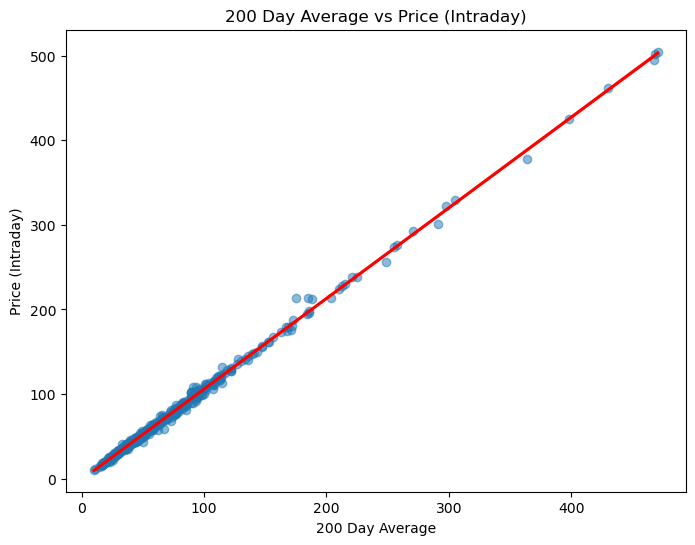

In [25]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the SQLite database
conn = sqlite3.connect('etf_data.db')

# Load data into a pandas DataFrame
df = pd.read_sql_query("SELECT * FROM etfs", conn)
conn.close()

# Convert necessary columns to numeric, removing commas and converting strings if needed
df['price_(intraday)'] = pd.to_numeric(df['price_(intraday)']
                            .apply(lambda x: x.replace(',', '') if isinstance(x, str) else x), errors='coerce')
df['50_day_average'] = pd.to_numeric(df['50_day_average']
                            .apply(lambda x: x.replace(',', '') if isinstance(x, str) else x), errors='coerce')
df['200_day_average'] = pd.to_numeric(df['200_day_average']
                            .apply(lambda x: x.replace(',', '') if isinstance(x, str) else x), errors='coerce')

# Drop rows with NaN values to ensure clean data for visualization
df.dropna(subset=['price_(intraday)', '50_day_average', '200_day_average'], inplace=True)

# Visualization 1: Histograms of the features
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.histplot(df['price_(intraday)'], kde=True, color='blue')
plt.title('Distribution of Price (Intraday)')

plt.subplot(1, 3, 2)
sns.histplot(df['50_day_average'], kde=True, color='green')
plt.title('Distribution of 50 Day Average')

plt.subplot(1, 3, 3)
sns.histplot(df['200_day_average'], kde=True, color='red')
plt.title('Distribution of 200 Day Average')
plt.tight_layout()

# Visualization 2: Scatter plot with regression line between '50_day_average' and 'price_(intraday)'
plt.figure(figsize=(8, 6))
sns.regplot(x='50_day_average', y='price_(intraday)', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('50 Day Average vs Price (Intraday)')
plt.xlabel('50 Day Average')
plt.ylabel('Price (Intraday)')

plt.figure(figsize=(8, 6))
sns.regplot(x='200_day_average', y='price_(intraday)', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('200 Day Average vs Price (Intraday)')
plt.xlabel('200 Day Average')
plt.ylabel('Price (Intraday)')

# Show all plots
plt.show()


In [ ]:

### Summary for visualization: 
    
Loads Data: It connects to your SQLite database, retrieves the data, and ensures that relevant columns are numeric.
    
Data Cleaning: Converts string data to numeric where necessary and handles missing values by dropping rows with NaNs.
    
Histograms: Visualizes the distribution of 'price_(intraday)', '50_day_average', and '200_day_average' to understand their individual characteristics.
    
Scatter Plot with Regression Line: Analyzes the relationship between '50_day_average' and 'price_(intraday)'.
    
Correlation Heatmap: Provides a heatmap of correlations between the numerical variables, offering insights into their relationships.
    
This approach gives a thorough visual exploration of your ETF data, highlighting key patterns and correlations which can inform further analysis or investment decisions.

In [ ]:
### Cluster Analysis

/Users/anvitharayala/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


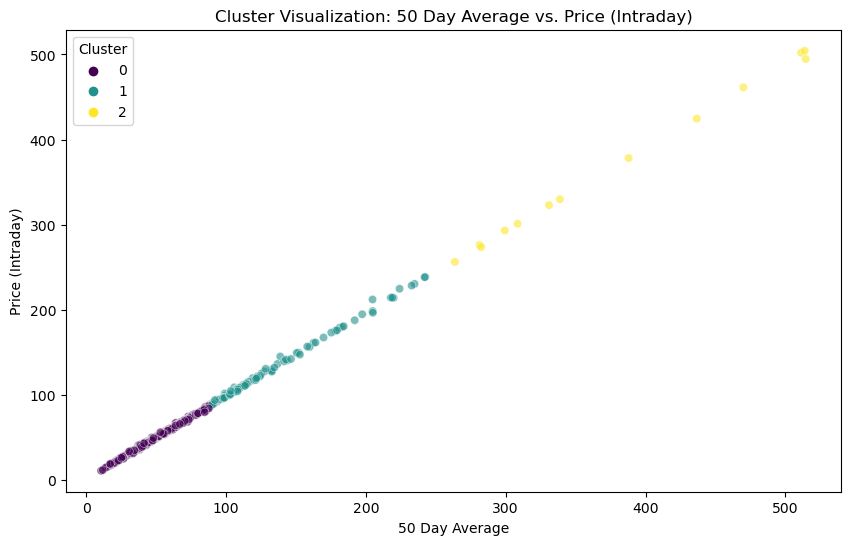

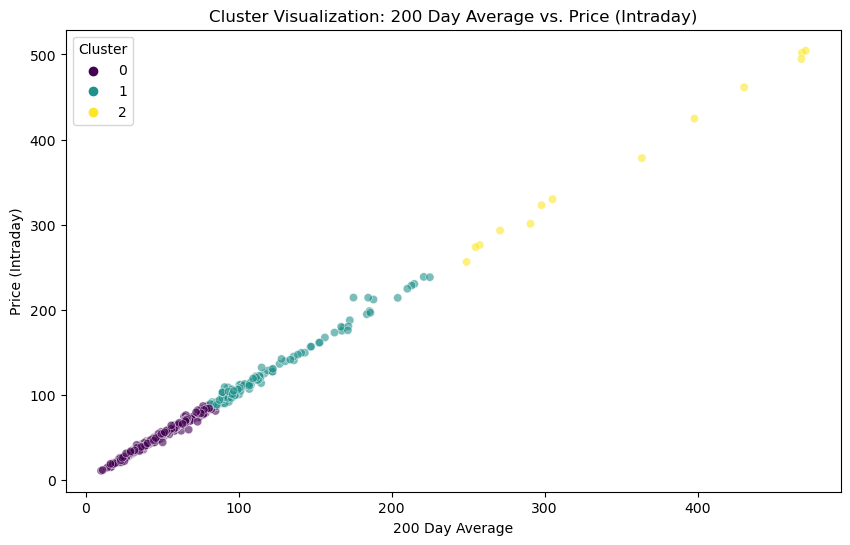

Cluster centers:
 [[ 44.84595062  45.402       43.1137037 ]
 [129.64182692 131.65663462 121.51701923]
 [370.57307692 379.91923077 347.99307692]]
Count in each cluster:
 cluster
0    405
1    104
2     13
Name: count, dtype: int64


In [26]:
import pandas as pd
import sqlite3
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the SQLite database
conn = sqlite3.connect('etf_data.db')

# Load data into a pandas DataFrame
df = pd.read_sql_query("SELECT * FROM etfs", conn)
conn.close()

# Convert necessary columns to numeric, removing commas and converting strings if needed
df['price_(intraday)'] = pd.to_numeric(df['price_(intraday)']
                            .apply(lambda x: x.replace(',', '') if isinstance(x, str) else x), errors='coerce')
df['50_day_average'] = pd.to_numeric(df['50_day_average']
                            .apply(lambda x: x.replace(',', '') if isinstance(x, str) else x), errors='coerce')
df['200_day_average'] = pd.to_numeric(df['200_day_average']
                            .apply(lambda x: x.replace(',', '') if isinstance(x, str) else x), errors='coerce')

# Drop rows with NaN values to ensure clean data for clustering
df.dropna(subset=['price_(intraday)', '50_day_average', '200_day_average'], inplace=True)

# Selecting the columns to be used in the clustering
X = df[['price_(intraday)', '50_day_average', '200_day_average']]

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=0)  # The number of clusters can be changed based on domain knowledge or experimentation
kmeans.fit(X)

# Assign the clusters to each data point
df['cluster'] = kmeans.labels_

# Visualization of the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='50_day_average', y='price_(intraday)', hue='cluster', data=df, palette='viridis', alpha=0.6)
plt.title('Cluster Visualization: 50 Day Average vs. Price (Intraday)')
plt.xlabel('50 Day Average')
plt.ylabel('Price (Intraday)')
plt.legend(title='Cluster')
plt.show()

# Visualization of the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='200_day_average', y='price_(intraday)', hue='cluster', data=df, palette='viridis', alpha=0.6)
plt.title('Cluster Visualization: 200 Day Average vs. Price (Intraday)')
plt.xlabel('200 Day Average')
plt.ylabel('Price (Intraday)')
plt.legend(title='Cluster')
plt.show()

# Optional: print some statistics about the clusters
print("Cluster centers:\n", kmeans.cluster_centers_)
print("Count in each cluster:\n", df['cluster'].value_counts())


/Users/anvitharayala/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


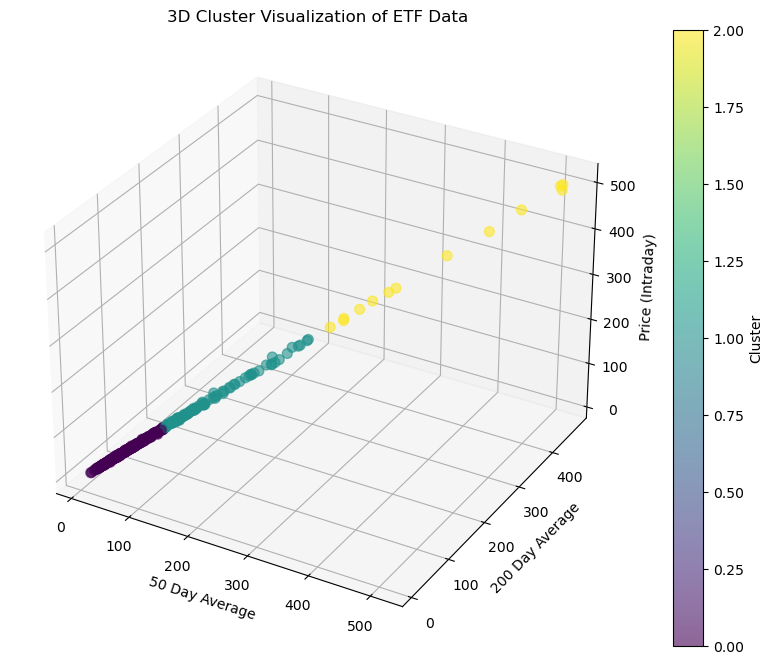

In [27]:
import pandas as pd
import sqlite3
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Connect to the SQLite database
conn = sqlite3.connect('etf_data.db')

# Load data into a pandas DataFrame
df = pd.read_sql_query("SELECT * FROM etfs", conn)
conn.close()

# Convert necessary columns to numeric, removing commas and converting strings if needed
df['price_(intraday)'] = pd.to_numeric(df['price_(intraday)']
                            .apply(lambda x: x.replace(',', '') if isinstance(x, str) else x), errors='coerce')
df['50_day_average'] = pd.to_numeric(df['50_day_average']
                            .apply(lambda x: x.replace(',', '') if isinstance(x, str) else x), errors='coerce')
df['200_day_average'] = pd.to_numeric(df['200_day_average']
                            .apply(lambda x: x.replace(',', '') if isinstance(x, str) else x), errors='coerce')

# Drop rows with NaN values to ensure clean data for clustering
df.dropna(subset=['price_(intraday)', '50_day_average', '200_day_average'], inplace=True)

# Selecting the columns to be used in the clustering
X = df[['price_(intraday)', '50_day_average', '200_day_average']]

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=0)  # Adjust the number of clusters as necessary
kmeans.fit(X)

# Assign the clusters to each data point
df['cluster'] = kmeans.labels_

# 3D Visualization of the clusters
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['50_day_average'], df['200_day_average'], df['price_(intraday)'],
                     c=df['cluster'], cmap='viridis', marker='o', alpha=0.6, s=50)

# Axis labels
ax.set_xlabel('50 Day Average')
ax.set_ylabel('200 Day Average')
ax.set_zlabel('Price (Intraday)')

# Title and color bar
plt.title('3D Cluster Visualization of ETF Data')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster')

# Show plot
plt.show()
